<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_05_auto_ml_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [0]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v1'

In [2]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

Cloning into 'dl-projects'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1086 (delta 90), reused 29 (delta 12), pack-reused 936
Receiving objects: 100% (1086/1086), 76.20 MiB | 28.56 MiB/s, done.
Resolving deltas: 100% (638/638), done.


In [0]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [0]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

import featuretools as ft

import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA

# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer

# from sklearn.ensemble import RandomForestClassifier

# from scikitplot.plotters import plot_precision_recall_curve

from dateutil.relativedelta import relativedelta

from IPython.display import display

from utils import *
from preprocess import *

import xgboost as xgb

np.set_printoptions(threshold=sys.maxsize)

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

from utils import feature_selection, plot_feature_importances
from plot import plot_correlation_matrix, plot_labelled_scatter

In [6]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [7]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.pkl"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

total 3076M
-rw------- 1 root root 1528M Jan  7 00:07 feature_matrix_d2_v1_origin.pkl
-rw------- 1 root root 1548M Jan  7 00:07 feature_matrix_d2_v1.pkl
total 25M
-rw-r--r-- 1 root root  1M Jan 11 23:52 4D.zip
-rw-r--r-- 1 root root 25M Jan 11 23:52 labels.csv


In [0]:
data = pd.read_pickle(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959893 entries, 0 to 959892
Columns: 213 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(2)
memory usage: 1.5 GB


## Exploratory Data Analysis

### View data

In [0]:
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [12]:
feature_matrix.columns

Index(['time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
       'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
       'MIN(Results.DrawNo)',
       ...
       'PERCENTILE(MAX(Results.DrawNo))',
       'PERCENTILE(TREND(Results.LuckyNo, DrawDate))',
       'PERCENTILE(LAST(Results.TotalStrike))',
       'PERCENTILE(LAST(Results.LuckyNo))',
       'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
       'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize'],
      dtype='object', length=210)

In [13]:
feature_matrix[feature_matrix['Label'] == 1 ].tail(4)

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
950205,2019-12-01,0.0,0.0,127054.467100,9957,1,479318,9957,1,140498,9957,1,311519.333333,0.0,0.0,-0.012912,9957,1,100862,479318,78019200.0,9,89613,9,2803674,0.0,0.0,0.032599,1,16,9,0,669254340.0,63521.940426,2.338165e+08,0.274341,1.452695e+08,29218.946689,0.0,0.0,...,460830.857063,0.0,1.0,5004.820912,1.0,266657.801609,27,6,0,0.50005,0.50005,0.8357,0.916225,0.4834,0.32300,0.32300,0.9958,0.50005,0.89905,0.50005,0.50005,0.50005,0.485937,0.56675,0.50005,0.9958,0.50005,0.3915,0.9958,0.56380,0.56675,0.50005,0.50005,0.9958,0.50005,0.8226,1.0,1,1,1
950206,2019-12-01,0.0,0.0,87070.473740,9964,1,343510,9964,1,100096,9964,1,220612.090909,0.0,0.0,-0.225108,9964,1,69635,343510,46483200.0,11,109604,11,2426733,0.0,0.0,0.031344,1,17,2,0,750643140.0,43536.467551,1.666614e+08,0.188005,9.967259e+07,20027.865006,0.0,0.0,...,460467.145418,0.0,1.0,4999.691371,1.0,261837.337829,10,11,0,0.50005,0.50005,0.9263,0.035232,0.3364,0.56205,0.56205,0.9965,0.50005,0.74750,0.50005,0.50005,0.50005,0.329597,0.02420,0.50005,0.9965,0.50005,0.0351,0.9965,0.04675,0.02420,0.50005,0.50005,0.9965,0.50005,0.1111,1.0,1,1,1
950207,2019-12-01,0.0,0.0,111384.241449,9989,1,434715,9989,1,41692,9989,1,219502.777778,0.0,0.0,0.437460,9989,1,90599,434715,93031200.0,9,89901,9,1975525,0.0,0.0,0.031669,1,27,5,0,868233540.0,55681.529797,2.109426e+08,0.240496,1.274390e+08,25613.543923,0.0,0.0,...,457987.417431,0.0,1.0,5110.967890,1.0,253949.170276,27,12,0,0.50005,0.50005,0.8375,0.122710,0.1801,0.32300,0.32300,0.9990,0.50005,0.02170,0.50005,0.50005,0.50005,0.792313,0.20020,0.50005,0.9990,0.50005,0.1763,0.9990,0.74565,0.20020,0.50005,0.5000

In [0]:
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)

In [15]:
feature_matrix.tail(4)

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
954761,2019-12-01,0.0,0.0,155434.539862,9996,1,487818,9996,1,68194,9996,1,326569.100000,0.0,0.0,-0.815323,9996,1,102815,487818,87187200.0,10,99960,10,3265691,0.0,0.0,0.032118,1,3,2,0,814924740.0,77713.235214,2.903229e+08,0.335619,1.778420e+08,35747.401714,0.0,0.0,...,460345.713402,0.0,1.0,5005.842936,1.0,256090.035652,16,12,0,0.50005,0.50005,0.8913,0.569412,0.6652,0.44340,0.44340,0.9997,0.50005,0.46870,0.50005,0.50005,0.50005,0.075468,0.69205,0.50005,0.9997,0.50005,0.8609,0.9997,0.68550,0.69205,0.50005,0.50005,0.9997,0.50005,0.8989,0.0,0,1,1
950811,2019-12-01,0.0,0.0,138496.513075,9997,1,470818,9997,1,43592,9997,1,285199.153846,0.0,0.0,-0.280090,9997,1,98916,470818,67024800.0,13,129961,13,3707589,0.0,0.0,0.032002,1,9,7,0,864518340.0,69249.009689,2.595765e+08,0.299046,1.585759e+08,31853.497629,0.0,0.0,...,460261.362761,0.0,1.0,5038.913323,1.0,253790.953564,3,1,0,0.50005,0.50005,0.9729,0.427885,0.7969,0.76950,0.76950,0.9998,0.50005,0.06290,0.50005,0.50005,0.50005,0.296167,0.46660,0.50005,0.9998,0.50005,0.6019,0.9998,0.37160,0.46660,0.50005,0.50005,0.9998,0.50005,0.6215,0.0,0,1,1
955548,2019-12-01,0.0,0.0,170578.819963,9998,1,479318,9998,1,75394,9998,1,294284.777778,0.0,0.0,-0.227022,9998,1,100856,479318,94413600.0,9,89982,9,2648563,0.0,0.0,0.032145,1,21,7,0,800409540.0,85281.503787,3.183494e+08,0.368320,1.952260e+08,39228.214947,0.0,0.0,...,460350.677501,0.0,1.0,5018.324678,1.0,257469.127153,27,6,0,0.50005,0.50005,0.8379,0.604544,0.4210,0.32300,0.32300,0.9999,0.50005,0.55070,0.50005,0.50005,0.50005,0.328696,0.56675,0.50005,0.9999,0.50005,0.9640,0.9999,0.76015,0.56675,0.50005,0.50005

In [16]:
origin_data[origin_data.LuckyNo == 9957]

,DrawNo,DrawDate,PrizeType,LuckyNo
22933,140498,1998-09-16,3rdPrizeNo,9957
25390,151099,1999-05-11,SpecialNo8,9957
44467,234104,2004-06-05,ConsolationNo5,9957
53282,272406,2006-09-02,SpecialNo10,9957
53956,275306,2006-11-08,SpecialNo8,9957
79659,387113,2013-04-24,ConsolationNo7,9957
81901,396813,2013-11-10,SpecialNo8,9957
98026,467017,2017-10-18,1stPrizeNo,9957
100862,479318,2018-06-27,ConsolationNo4,9957
106753,504919,2019-12-22,ConsolationNo7,9957


In [17]:
feature_matrix.describe().round(2)

,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),STD(Results.PERCENTILE(TotalStrike)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
count,958948.0,958948.0,958948.00,959893.00,959893.0,959893.00,959893.00,959893.0,959893.00,959893.00,959893.0,959893.00,952257.0,952257.0,952257.00,959893.00,959893.0,959893.00,959893.00,9.589480e+05,959893.00,959893.00,959893.00,959893.00,952257.0,952257.0,952257.00,959893.0,959893.00,959893.00,959893.0,9.598930e+05,958948.00,9.589480e+05,958948.00,9.589480e+05,958948.00,958948.0,958948.0,958948.0,...,959893.00,952257.0,959893.0,959893.00,959893.0,959893.00,959893.0,959893.00,959893.0,959893.0,958948.0,959893.00,952257.00,959893.00,959893.00,959893.00,959893.00,959893.0,959893.00,958948.0,952257.0,952257.0,952257.00,959893.00,952257.0,959893.00,959893.0,958948.00,959893.00,958948.00,959893.00,952257.0,959893.0,959893.00,959893.0,959893.00,959893.00,959893.00,959893.0,959893.0
mean,0.0,0.0,111342.20,4999.18,1.0,390906.91,4999.18,1.0,83952.25,4999.18,1.0,237399.51,0.0,0.0,-0.00,4999.18,1.0,80532.69,390906.91,8.234844e+07,9.05,45042.83,9.05,2168380.75,0.0,0.0,0.03,1.0,15.66,6.67,0.0,6.586662e+08,55666.09,2.109083e+08,0.28,1.274557e+08,25606.24,0.0,0.0,0.0,...,390647.83,0.0,1.0,4997.24,1.0,223470.76,15.8,6.51,0.0,0.5,0.5,0.50,0.50,0.50,0.50,0.50,0.50,0.5,0.50,0.5,0.5,0.5,0.50,0.50,0.5,0.50,0.5,0.50,0.50,0.50,0.50,0.5,0.5,0.50,0.5,0.50,0.03,0.03,1.0,1.0
std,0.0,0.0,25772.65,2886.68,0.0,59335.80,2886.68,0.0,42863.89,2886.68,0.0,45425.90,0.0,0.0,0.66,2886.68,0.0,13646.27,59335.80,3.895532e+07,3.16,31606.21,3.16,904878.09,0.0,0.0,0.00,0.0,8.81,3.37,0.0,1.119074e+08,12886.48,4.813546e+07,0.06,2.949965e+07,5927.49,0.0,0.0,0.0,...,41330.44,0.0,0.0,136.49,0.0

In [18]:
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


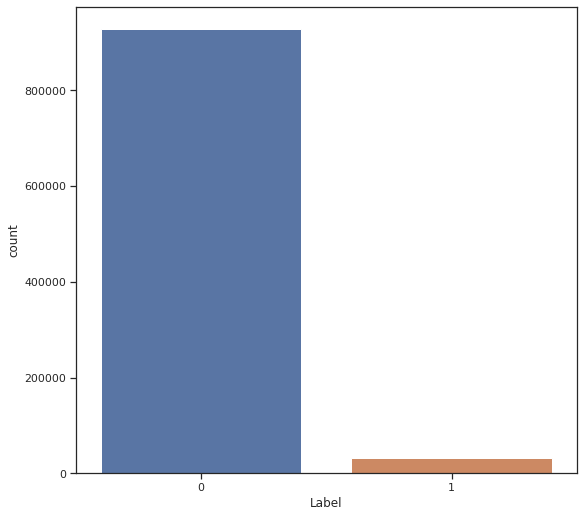

In [19]:
plt.figure(figsize=(8, 8))
sns.countplot('Label', data=feature_matrix)

In [20]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.CUM_SUM(DrawNo))                       7636
SKEW(Results.TotalStrike)                           7636
TREND(Results.PERCENTILE(TotalStrike), DrawDate)    7636
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          7636
TREND(Results.CUM_SUM(DrawNo), DrawDate)            7636
                                                    ... 
CUM_SUM(MIN(Results.TotalStrike))                      0
NUM_UNIQUE(Results.MONTH(DrawDate))                    0
NUM_UNIQUE(Results.HOUR(DrawDate))                     0
NUM_UNIQUE(Results.DAY(DrawDate))                      0
time                                                   0
Length: 210, dtype: int64

In [21]:
feature_matrix.isnull().sum().sort_values(ascending=False)

SKEW(Results.CUM_SUM(DrawNo))                       7636
SKEW(Results.TotalStrike)                           7636
TREND(Results.PERCENTILE(TotalStrike), DrawDate)    7636
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          7636
TREND(Results.CUM_SUM(DrawNo), DrawDate)            7636
                                                    ... 
CUM_SUM(MIN(Results.TotalStrike))                      0
NUM_UNIQUE(Results.MONTH(DrawDate))                    0
NUM_UNIQUE(Results.HOUR(DrawDate))                     0
NUM_UNIQUE(Results.DAY(DrawDate))                      0
time                                                   0
Length: 210, dtype: int64

In [22]:
len(feature_matrix[feature_matrix.isnull().any(axis=1)].time.unique())

96

In [23]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize
9017,2012-01-01,0.0,0.0,126014.206582,123,1,317909,123,1,139698,123,1,228803.5,NaN,NaN,NaN,123,1,63742,317909,339379200.0,2,246,2,457607,NaN,NaN,NaN,1,29,8,0,421027140.0,63009.063553,2.399773e+08,0.390354,1.443593e+08,28985.721174,0.0,0.0,...,320311.414903,NaN,1.0,5002.374694,1.0,196454.126658,31,5,0,0.50005,0.50005,0.003902,NaN,0.026213,0.013057,0.013057,0.012406,0.50005,0.898299,0.50005,NaN,NaN,NaN,0.348174,NaN,0.012406,0.50005,0.962392,0.012406,0.996485,0.348174,NaN,0.50005,0.012406,0.50005,0.772186,0.0,0,1,1
8619,2012-01-01,0.0,0.0,139944.917278,135,1,322109,135,1,124197,135,1,223153.0,NaN,NaN,NaN,135,1,64702,322109,378259200.0,2,270,2,446306,NaN,NaN,NaN,1,31,8,0,452390340.0,69939.255825,2.674696e+08,0.433508,1.603340e+08,32173.358544,0.0,0.0,...,320063.072897,NaN,1.0,4988.969509,1.0,194912.885674,26,8,0,0.50005,0.50005,0.004702,NaN,0.024612,0.013057,0.013057,0.013607,0.50005,0.856378,0.50005,NaN,NaN,NaN,0.383192,NaN,0.013607,0.50005,0.990259,0.013607,0.997791,0.383192,NaN,0.50005,0.013607,0.50005,0.721761,0.0,0,1,1
9519,2012-01-01,0.0,0.0,61592.536175,185,1,257505,185,1,170400,185,1,213952.5,NaN,NaN,NaN,185,1,49848,257505,166406400.0,2,370,2,427905,NaN,NaN,NaN,1,15,7,0,361756740.0,30741.219027,1.176671e+08,0.190577,7.009099e+07,14142.135624,0.0,0.0,...,320322.563145,NaN,1.0,5000.346243,1.0,198724.182234,23,10,0,0.50005,0.50005,0.006703,NaN,0.022211,0.013057,0.013057,0.018609,0.50005,0.950625,0.50005,NaN,NaN,NaN,0.086193,NaN,0.018609,0.50005,0.095903,0.018609,0.957873,0.086193,NaN,0.50005,0.018609,0.50005,0.632316,0.0,0,1,1
7564,2012-01-01,0.0,0.0,94262.990786,234,1,233204,234

### Data Cleansing

In [0]:
## Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [25]:
feature_matrix.isnull().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                    0
MAX(Results.CUM_MEAN(LuckyNo))                   0
SKEW(Results.CUM_MEAN(DrawNo))                   0
MEAN(Results.CUM_MEAN(LuckyNo))                  0
MEAN(Results.CUM_SUM(DrawNo))                    0
                                                ..
CUM_SUM(LAST(Results.DrawNo))                    0
CUM_SUM(SKEW(Results.DrawNo))                    0
CUM_SUM(TREND(Results.TotalStrike, DrawDate))    0
CUM_SUM(SKEW(Results.LuckyNo))                   0
time                                             0
Length: 210, dtype: int64

In [26]:
feature_matrix.isna().sum().sort_values(ascending=False)

LAST(Results.PrizeType)_Prize                    0
MAX(Results.CUM_MEAN(LuckyNo))                   0
SKEW(Results.CUM_MEAN(DrawNo))                   0
MEAN(Results.CUM_MEAN(LuckyNo))                  0
MEAN(Results.CUM_SUM(DrawNo))                    0
                                                ..
CUM_SUM(LAST(Results.DrawNo))                    0
CUM_SUM(SKEW(Results.DrawNo))                    0
CUM_SUM(TREND(Results.TotalStrike, DrawDate))    0
CUM_SUM(SKEW(Results.LuckyNo))                   0
time                                             0
Length: 210, dtype: int64

In [27]:
feature_matrix[feature_matrix.isnull().any(axis=1)].head()

,time,STD(Results.LuckyNo),STD(Results.TotalStrike),STD(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MAX(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MIN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),MEAN(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),SKEW(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),LAST(Results.DrawNo),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.LuckyNo),SUM(Results.TotalStrike),SUM(Results.DrawNo),"TREND(Results.TotalStrike, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.DrawNo, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.CUM_MEAN(DrawNo)),STD(Results.TIME_SINCE(DrawDate)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_MEAN(TotalStrike)),STD(Results.PERCENTILE(LuckyNo)),...,CUM_MEAN(MAX(Results.DrawNo)),"CUM_MEAN(TREND(Results.LuckyNo, DrawDate))",CUM_MEAN(LAST(Results.TotalStrike)),CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(NUM_UNIQUE(Results.PrizeType)),CUM_MEAN(MEAN(Results.DrawNo)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(STD(Results.TotalStrike)),PERCENTILE(SUM(Results.LuckyNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(COUNT(Results)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(SKEW(Results.LuckyNo)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(LAST(Results.DrawNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(MAX(Results.TotalStrike)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(MAX(Results.DrawNo)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(LAST(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(MEAN(Results.DrawNo)),TotalStrike,Label,MODE(Results.PrizeType)_Prize,LAST(Results.PrizeType)_Prize


### Feature Selection

In [0]:
# Feature scaling first??

In [29]:
print(feature_matrix.shape)
feature_matrix.columns

(959893, 210)


Index(['time', 'STD(Results.LuckyNo)', 'STD(Results.TotalStrike)',
       'STD(Results.DrawNo)', 'MAX(Results.LuckyNo)',
       'MAX(Results.TotalStrike)', 'MAX(Results.DrawNo)',
       'MIN(Results.LuckyNo)', 'MIN(Results.TotalStrike)',
       'MIN(Results.DrawNo)',
       ...
       'PERCENTILE(MAX(Results.DrawNo))',
       'PERCENTILE(TREND(Results.LuckyNo, DrawDate))',
       'PERCENTILE(LAST(Results.TotalStrike))',
       'PERCENTILE(LAST(Results.LuckyNo))',
       'PERCENTILE(NUM_UNIQUE(Results.PrizeType))',
       'PERCENTILE(MEAN(Results.DrawNo))', 'TotalStrike', 'Label',
       'MODE(Results.PrizeType)_Prize', 'LAST(Results.PrizeType)_Prize'],
      dtype='object', length=210)

In [30]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))

Original shape:  (959893, 207)
0 missing columns with threshold: 90.
46 zero variance columns.
108 collinear columns removed with threshold: 0.95.
Total columns removed:  154
Shape after feature selection: (959893, 53).


In [31]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 53),
 Index(['STD(Results.DrawNo)', 'MAX(Results.LuckyNo)', 'MAX(Results.DrawNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.LuckyNo)', 'SUM(Results.DrawNo)',
        'TREND(Results.DrawNo, DrawDate)', 'DAY(first_Results_time)',
        'MONTH(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))', 'STD(Results.CUM_SUM(DrawNo))',
        'STD(Results.CUM_MEAN(LuckyNo))', 'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))', 'MIN(Results.CUM_MEAN(LuckyNo))',
        'MODE(Results.DAY(DrawDate))', 'MODE(Results.MONTH(DrawDate))',
        'MEAN(Results.TIME_SINCE(DrawDate))',
        'MEAN(Results.PERCENTILE(DrawNo))', 'MEAN(Results.CUM_MEAN(LuckyNo))',
        'SKEW(Results.CUM_SUM(DrawNo))', 'SKEW(Results.CUM_MEAN(LuckyNo))',
        'LAST(Resul

In [0]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [33]:
# Check without feature selection
corrs = feature_matrix.corr().sort_values('Label')
corrs['Label'].tail(100)

TREND(Results.TIME_SINCE(DrawDate), DrawDate)    0.000523
PERCENTILE(SUM(Results.DrawNo))                  0.000610
CUM_SUM(SUM(Results.DrawNo))                     0.000678
TREND(Results.PERCENTILE(LuckyNo), DrawDate)     0.000687
MONTH(first_Results_time)                        0.000858
                                                   ...   
CUM_MEAN(LAST(Results.TotalStrike))                   NaN
CUM_MEAN(NUM_UNIQUE(Results.PrizeType))               NaN
HOUR(LAST(Results.DrawDate))                          NaN
MODE(Results.PrizeType)_Prize                         NaN
LAST(Results.PrizeType)_Prize                         NaN
Name: Label, Length: 100, dtype: float64

In [34]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')
corrs['Label'].tail(20)

TREND(Results.PERCENTILE(TotalStrike), DrawDate)   -0.000156
PERCENTILE(COUNT(Results))                         -0.000139
PERCENTILE(LAST(Results.DrawNo))                   -0.000094
MODE(Results.DAY(DrawDate))                         0.000471
PERCENTILE(SUM(Results.DrawNo))                     0.000610
TREND(Results.PERCENTILE(LuckyNo), DrawDate)        0.000687
MONTH(first_Results_time)                           0.000858
PERCENTILE(TREND(Results.DrawNo, DrawDate))         0.000912
LAST(Results.CUM_MEAN(LuckyNo))                     0.000988
MAX(Results.CUM_MEAN(LuckyNo))                      0.001007
MEAN(Results.PERCENTILE(DrawNo))                    0.001149
TREND(Results.CUM_MEAN(LuckyNo), DrawDate)          0.001493
TREND(Results.PERCENTILE(DrawNo), DrawDate)         0.001528
PERCENTILE(MIN(Results.TotalStrike))                0.001564
CUM_SUM(MIN(Results.TotalStrike))                   0.001572
MIN(Results.DrawNo)                                 0.001718
MAX(Results.PERCENTILE(T

### Balancing data

In [0]:
from sklearn.decomposition import PCA
import pylab as pl
from collections import Counter

In [37]:
X = feature_matrix_selection.drop(columns = ['time', 'Label', 'TotalStrike'])
X.shape

(959893, 53)

In [39]:
y = feature_matrix_selection['Label']
y.shape, y.value_counts()[0], y.value_counts()[1]

((959893,), 927839, 32054)

In [0]:
#X.info()

In [0]:
def plot_pca(X, y):
  X_normalized = StandardScaler().fit(X).transform(X)  
  pca = PCA(n_components = 2).fit(X_normalized)
  X_pca = pca.transform(X_normalized)
  plt.figure(figsize=(8, 8))
  plot_labelled_scatter(X_pca, y, ['0', '1'])

#plot(X,y)

In [0]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

In [0]:
def plot_resampling(X, y, sampling, ax):
    X_res, y_res = sampling.fit_resample(X, y)
    plt.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor='k')
    # make nice plotting
    plt.spines['top'].set_visible(False)
    plt.spines['right'].set_visible(False)
    plt.get_xaxis().tick_bottom()
    plt.get_yaxis().tick_left()
    plt.spines['left'].set_position(('outward', 10))
    plt.spines['bottom'].set_position(('outward', 10))
    return Counter(y_res)

In [0]:
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss)
from imblearn.pipeline import make_pipeline

In [70]:
ratio = 0.8
sampler = AllKNN(random_state=42)
%time X_bal, y_bal = sampler.fit_sample(X, y)
print('Undersampling {}'.format(Counter(y_bal)))

CPU times: user 3min 52s, sys: 143 ms, total: 3min 52s
Wall time: 3min 52s
TomeLinks undersampling Counter({0: 834459, 1: 32054})


In [0]:
TomekLinks??

## Modeling

In [0]:
def predict(dt, feature_matrix, return_probs = False): 
   
    feature_matrix['date'] = feature_matrix['time']

    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['date'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['date'] < dt, 'Label']

    print(f"Size of test labels {len(test_labels)}")
    print(f"Size of train labels {len(train_labels)}")
    
    # Features
    X_train = feature_matrix[feature_matrix['date'] < dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['date'] == dt].drop(columns = ['NumberId', 'time',
                                                                                     'date', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    print(f"Size of X train {len(X_train)}")
    print(f"Size of X test  {len(X_test)}")
   
    feature_names = list(X_train.columns)
    
    # Impute and scale features
    pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'constant', fill_value=0)), 
                      ('scaler', StandardScaler())])

    # Fit and transform training data
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    ## Balance the data??
    sampler = AllKNN(random_state=42)
    print(train_labels.shape)
    X_bal, y_bal = sampler.fit_sample(X_train, train_labels)
    X_train = X_bal
    train_labels = y_bal
    print(train_labels.shape)

    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))
    
    # https://xgboost.readthedocs.io/en/latest/parameter.html
    # https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
    # https://stats.stackexchange.com/questions/224512/reduce-false-positives-with-xgboost
    hit_ratio = float(train_labels.value_counts()[0]/train_labels.value_counts()[1]) 
    print(f"Hit ratio - {hit_ratio}")

     # Create the classifier
    model = xgb.XGBClassifier(n_jobs=-1, 
                             random_state = 42,
                             n_estimators=100, 
                             max_depth=3,
                             min_child_weight=1,
                             # criterion = 'entropy',
                             scale_pos_weight=hit_ratio
                             )

    # Train 
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    # Total positive
    positive = np.where((predictions==1))
    print('Total predicted to be positive: ', len(positive[0]))
  
    # Calculate metrics
    rpt = classification_report(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    print('Classification report')
    print(rpt)
    print('Confusion matrix')
    print(cm)

    # Total predicted matches
    print('Predicted matches')
    pred = np.where((predictions==1))
    print(len(pred[0]), pred)
  
    if len(positive[0]) > 0:
    
      # Matching draws
      print('Matched draws')
      md = np.where((predictions==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['date'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      
      display(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(len(positive[0])))                                                   
    else:
      print('No luck this month')                 

    # Feature importances
    fi = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
    
    if return_probs:
        return fi, probs
    
    return fi

In [0]:
%time june_2019 = predict(pd.datetime(2019,6,1), feature_matrix_selection)

Size of test labels 10000
Size of train labels 889893
Size of X train 889893
Size of X test  10000
(889893,)


In [0]:
bnormalized_fi = plot_feature_importances(june_2019)

In [0]:
normalized_fi.head(70)

In [0]:
# from sklearn.datasets import make_classification

# a, b = make_classification(
#     n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
#     n_informative=3, n_redundant=1, flip_y=0,
#     n_features=20, n_clusters_per_class=1,
#     n_samples=100, random_state=10
# )